In [1]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load models

In [2]:
from classification.models.M5 import M5PLModule
from classification.models.CRNN import CRNNPLModule
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule
from classification.models.DeepRecursiveCNN import DeepRecursiveCNNPLModule

models = {}

In [3]:
loaded_dict = torch.load("/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_vanilla.p")
hparams = loaded_dict["hparams"]
hparams['batch_size'] = 30

model = M5PLModule(hparams)
model.model.load_state_dict(loaded_dict["state_dict"])
model = model.eval().cuda()

models[model.__class__.__name__] = model

In [4]:
state_dict_path = '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/SpectrogramCNN/optuna_90.5.p'
loaded_dict = torch.load(state_dict_path)
loaded_dict['hparams']['batch_size'] = 5
model = SpectrogramCNNPLModule(loaded_dict['hparams'])
model.model.load_state_dict(loaded_dict['state_dict'])
model = model.cuda()
model = model.eval()

models[model.__class__.__name__] = model

In [5]:
model_state_dict_path = "/nfs/students/summer-term-2020/project-4/yan/models/best_model_state_dict.pt"

hparams = {
    "batch_size": 2,
    "learning_rate": 0.001,
    "weight_decay": 0,
    "lr_decay": 1
}

model = DeepRecursiveCNNPLModule(hparams)
model.model.load_state_dict(torch.load(model_state_dict_path))
model = model.eval()

models[model.__class__.__name__] = model

In [6]:
state_dict_path = '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN/vanilla0.886.p'

loaded_dict = torch.load(state_dict_path)

model = CRNNPLModule(loaded_dict['hparams'])
model.model.load_state_dict(loaded_dict['state_dict'])
model = model.eval().cuda()

models[model.__class__.__name__] = model

In [45]:
fast_model = {'SpectrogramCNNPLModule': models['SpectrogramCNNPLModule']}

# Load Data

In [7]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [8]:
for model_name in models:
    #datasetHandler.load(models[model_name], 'training')
    datasetHandler.load(models[model_name], 'validation')
    #datasetHandler.load(models[model_name], 'testing')

Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_8k/
Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_48k/


# Attacks

## Functional Attacks

In [125]:
from attacks.functionalVolume import FunctionalVolumeAttack

attack_parameters = {'epsilonVolume': 0.1, 'epsilonPGD': 0.001, 'num_iter': 10}
attacks = {}

for model_name in models:
    valid_loader = models[model_name].val_dataloader()
    fva = FunctionalVolumeAttack(model, valid_loader, attack_parameters, save_samples=True)
    fva.attack()
    attacks[model_name] = fva
    
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

100%|██████████| 338/338 [01:46<00:00,  3.16it/s]

SpectrogramCNNPLModule
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.001, 'num_iter': 10}
Early stopping: 	False (-1)

Successfully attacked:	503
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.34
Perturbed Accurracy: 	0.58



## FGSM

In [9]:
from attacks.pgd import ProjectedGradientDescent

epsilons = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

attacks = {}
for model_name in models:
    print(model_name)
    
    for eps in epsilons:
        attack_parameters = {'epsilon': eps, 'num_iter': 1}
        valid_loader = models[model_name].val_dataloader()
        fgsm = ProjectedGradientDescent(models[model_name], valid_loader, attack_parameters, save_samples=True)
        fgsm.attack(cudnn_RNN_backward_bug=True)
        attacks.setdefault(model_name, []).append(fgsm)

M5PLModule


100%|██████████| 57/57 [00:04<00:00, 13.27it/s]


SpectrogramCNNPLModule


100%|██████████| 338/338 [00:44<00:00,  7.57it/s]


DeepRecursiveCNNPLModule


100%|██████████| 844/844 [03:02<00:00,  4.63it/s]


CRNNPLModule


100%|██████████| 71/71 [00:33<00:00,  2.12it/s]


In [12]:
for model_name in attacks:
    print(model_name)
    print(attacks[model_name][3].report())
    print()

M5PLModule
Attack-Parameters:	{'epsilon': 0.005, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	795
Total attacked: 	1420
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37
{'success_rate': 0.5598591549295775, 'acc': 0.37048014226437465}

SpectrogramCNNPLModule
Attack-Parameters:	{'epsilon': 0.005, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	529
Total attacked: 	1520
Total processed:	1687

Success-Rate: 		0.35
Perturbed Accurracy: 	0.59
{'success_rate': 0.3480263157894737, 'acc': 0.5874333135743924}

DeepRecursiveCNNPLModule
Attack-Parameters:	{'epsilon': 0.005, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	253
Total attacked: 	1422
Total processed:	1687

Success-Rate: 		0.18
Perturbed Accurracy: 	0.69
{'success_rate': 0.1779184247538678, 'acc': 0.6929460580912863}

CRNNPLModule
Attack-Parameters:	{'epsilon': 0.005, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	83
Total attacked: 	1

In [13]:
from utils.Visual import draw_plot 

In [52]:
#colors = ['r', 'b', 'grey', 'g']
y = []
for i in range(len(attacks)):
    model_name = list(attacks.keys())[i]
    y_i = {'data': [attack.getAccuracy() for attack in attacks[model_name]]}
    #y_i['color'] = colors[i]
    y_i['label'] = model_name[:-8]
    if y_i['label'] == 'M5':
        y_i['label'] = "FullyConvolutional"
    y.append(y_i)

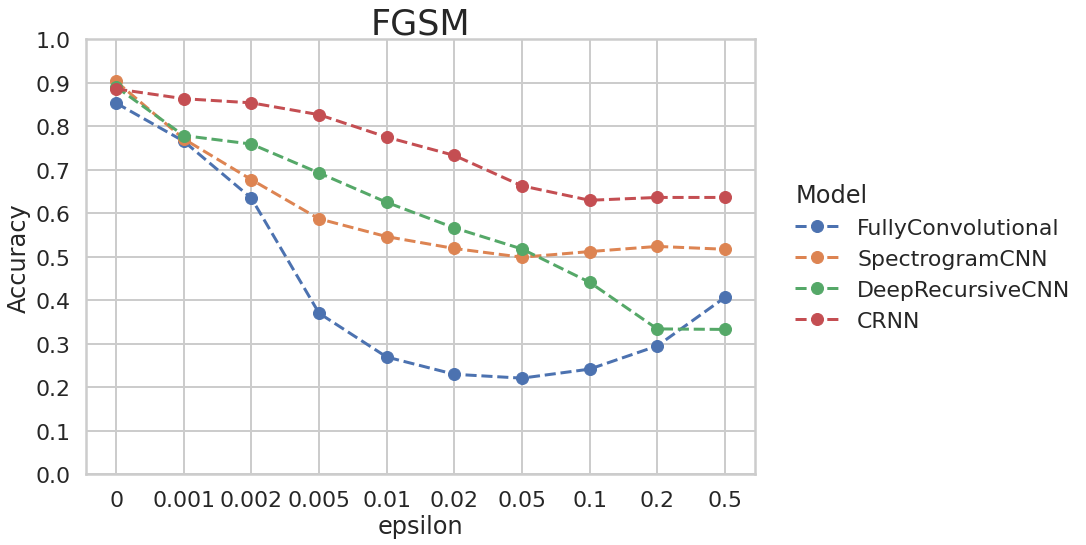

In [60]:
draw_plot(epsilons, data = y, legend_x_offset=1.5, title="FGSM",
          legend_title="Model", x_label="epsilon", y_label="Accuracy")

## PGD 

In [73]:
from attacks.pgd import ProjectedGradientDescent

attack_parameters = {'epsilon': 0.0005, 'num_iter': 10}
attacks = {}

for model_name in models:
    valid_loader = models[model_name].val_dataloader()
    fgsm = ProjectedGradientDescent(model, valid_loader, attack_parameters, save_samples=True)
    fgsm.attack()
    attacks[model_name] = fgsm
    
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

100%|██████████| 338/338 [04:25<00:00,  1.27it/s]


SpectrogramCNNPLModule
Attack-Parameters:	{'epsilon': 0.0005, 'num_iter': 10}
Early stopping: 	False (-1)

Successfully attacked:	229
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.15
Perturbed Accurracy: 	0.74



In [74]:
# attacks['SpectrogramCNNPLModule'].showAdversarialExample(target_class=1)

## Volume attacks

In [116]:
from attacks.volume import VolumeAttack

attack_parameters = {'epsilon': 0.1, 'num_iter': 10}
attacks = {}

for model_name in models:
    valid_loader = models[model_name].val_dataloader()
    attack = VolumeAttack(model, valid_loader, attack_parameters, save_samples=False)
    attack.attack()
    attacks[model_name] = attack
    
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

100%|██████████| 338/338 [01:43<00:00,  3.25it/s]

SpectrogramCNNPLModule
Attack-Parameters:	{'epsilon': 0.1, 'num_iter': 10}
Early stopping: 	False (-1)

Successfully attacked:	5
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.88



## Interpolation attack

In [60]:
from attacks.interpolation import InterpolationAttack

attacks = {}

for model_name in fast_model:
    valid_loader = models[model_name].getDataLoader('validation', batch_size=20)
    test_sound = 0.2*next(iter(valid_loader))['audio'][0]
    attack_parameters = {'epsilon': 0.2, 'num_iter': 10, 'overlay_sound': test_sound}
    attack = InterpolationAttack(model, valid_loader, attack_parameters, save_samples=False)
    attack.attack()
    attacks[model_name] = attack

100%|██████████| 85/85 [00:21<00:00,  3.90it/s]


In [59]:
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

M5
Attack-Parameters:	{'epsilon': 0.2, 'num_iter': 10, 'overlay_sound': tensor([-0.0449, -0.0255, -0.0231,  ..., -0.0050,  0.0054, -0.0017])}
Early stopping: 	False (-1)

Successfully attacked:	7
Total attacked: 	1356
Total processed:	1687

Success-Rate: 		0.01
Perturbed Accurracy: 	0.8



## Time stretching attack 

In [61]:
from attacks.speed import TimeStretchAttack

attack_parameters = {'num_iter': 30, 'lower': 0.5, 'upper': 1.5}
attacks = {}

for model_name in fast_model:
    valid_loader = models[model_name].getDataLoader('validation', batch_size=30)
    attack = TimeStretchAttack(model, valid_loader, attack_parameters, early_stopping=10)
    attack.attack()
    attacks[model_name] = attack

100%|██████████| 57/57 [00:42<00:00,  1.35it/s]


In [65]:
# attacks['M5'].showAdversarialExample(target_class=1)

In [66]:
#tsa.showAdversarialExample(target_class=0)
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

M5
Attack-Parameters:	{'num_iter': 30, 'lower': 0.5, 'upper': 1.5}
Early stopping: 	False (-1)

Successfully attacked:	108
Total attacked: 	1356
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.74



## Pitch attack

In [55]:
from attacks.pitch import PitchAttack

attack_parameters = {'num_iter': 5, 'lower': -1, 'upper': 5}
attacks = {}

for model_name in fast_model:
    valid_loader = models[model_name].getDataLoader('validation', batch_size=30)
    attack = PitchAttack(model, valid_loader, attack_parameters, early_stopping=10)
    attack.attack()
    attacks[model_name] = attack

  5%|▌         | 3/57 [00:19<05:52,  6.53s/it]

Early stopping


In [58]:
#attacks['M5'].showAdversarialExample(target_class=1)

In [57]:
attacks['M5'].report()

Attack-Parameters:	{'num_iter': 5, 'lower': -1, 'upper': 5}
Early stopping: 	True (10)

Successfully attacked:	14
Total attacked: 	95
Total processed:	120

Success-Rate: 		0.15
Perturbed Accurracy: 	0.68


{'success_rate': 0.14736842105263157, 'acc': 0.675}